In [1]:
import os
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import argparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages


def valid_path(arg):
    arg = os.path.abspath(arg)
    if not os.path.exists(arg):
        msg = f"The path {arg} does not exist!"
        raise argparse.ArgumentTypeError(msg)
    else:
        return arg


In [2]:
# Parse input arguments
# parser = argparse.ArgumentParser(description='Generate origin destination matrix')
# parser.add_argument('-gpkg_cities',
#                     help='path to all cities summary results geopackage',
#                     default='./data/output/November 2020/global_indicators_city_2020-11-24.gpkg',
#                     type=valid_path)
# parser.add_argument('-gpkg_hexes',
#                     help='path to all cities hexagon grid results geopackage',
#                     default='./data/output/November 2020/global_indicators_hex_250m_2020-11-24.gpkg',
#                     type=valid_path)
# args = parser.parse_args()

# dummy parsing for interactive debugging
class Object(object):
    pass

args = Object()
args.gpkg_cities = os.path.abspath('../process/data/output/global_indicators_city_2020-11-24.gpkg')
args.gpkg_hexes = os.path.abspath('../process/data/output/global_indicators_hex_250m_2020-11-24.gpkg')

cities = gpd.read_file(args.gpkg_cities, layer='all_cities_combined')

# cities

In [3]:
hexes={}
for city in cities.City:
    hexes[city] = gpd.read_file(args.gpkg_hexes, layer=city.lower().replace(' ','_'))

In [4]:
hexes.keys()

dict_keys(['Maiduguri', 'Mexico City', 'Baltimore', 'Phoenix', 'Seattle', 'Sao Paulo', 'Hong Kong', 'Chennai', 'Bangkok', 'Hanoi', 'Adelaide', 'Melbourne', 'Sydney', 'Auckland', 'Graz', 'Ghent', 'Olomouc', 'Odense', 'Cologne', 'Lisbon', 'Barcelona', 'Valencia', 'Vic', 'Bern', 'Belfast'])

In [5]:
print("""
Global Indicators project, 2020

Analysis and mapping of threshold values for urban design and transport planning features associated with
  - (A) ≥80% probability of engaging in walking for transport and 
  - (B) reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking

""")





Global Indicators project, 2020

Analysis and mapping of threshold values for urban design and transport planning features associated with
  - (A) ≥80% probability of engaging in walking for transport and 
  - (B) reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking




In [6]:
# Analysis set up
scenarios={
  'A':'≥80% probability of engaging in walking for transport', 
  'B':'reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking'
}
greq = '≥'
thresholds = {
'Mean 1000 m neighbourhood population per km²':{
  'variable':'local_nh_population_density',
  'A':{
    'threshold':5665,
    'interval':(4790, 6750),
    'interval_type':'95% CrI'
    },
  'B':{
    'threshold':6491,
    'interval':(5677, 7823),
    'interval_type':'95% CrI' 
    }
},
'Mean 1000 m neighbourhood street intersections per km²':{
  'variable':'local_nh_intersection_density',
  'A':{
    'threshold':98,
    'interval':(90, 110),
    'interval_type':'95% CrI'
    },
  'B':{
    'threshold':122,
    'interval':(106, 156),
    'interval_type':'95% CrI'
    }
},
# 'Public transport density (stops/km2)':{
#   'variable':'',
#   'A':{
#     'threshold':28,
#     'interval':(23, max),
#     'interval_type':'95% CrI'
#     },
#   'B':{
#     'notes':'Not a significant correlate'
#     }
# },
'Mean distance to nearest public transport stops (m)':{
  'variable':'pct_access_500m_pt_any_binary',
  'A':{
    'threshold':702,
    'interval':(553, 1254),
    'interval_type':'95% CrI',
    'notes':'threshold for above average prevalence'
    },
  'B':{
    'notes':'Not a significant correlate'
    }
},
'Mean distance to nearest park (m)':{
  'variable':'pct_access_500m_public_open_space_any_binary',
  'A':{
    'threshold':953,
    'interval':(705, 1220),
    'interval_type':'95% CrI',
    'notes':'threshold for above average prevalence'
    },
  'B':{
    'threshold':322,
    'interval': (0, 667),
    'interval_type':'95% CrI',
    'notes':'threshold for less than average inactivity'
    }
}}



In [13]:
fontprops = fm.FontProperties(size=8)
for city in hexes.keys():
    print(city)
    # create a PdfPages object
    pdf = PdfPages(f'reports/{city}_threshold_summary.pdf')
    for indicator in thresholds.keys():
        variable = thresholds[indicator]['variable']
        var_min = min(hexes[city][variable])        
        var_max = max(hexes[city][variable])
        # limits = (min(thresholds[indicator]['A']['interval'][0],thresholds[indicator]['B']['interval'][0],var_min),
        #          max(thresholds[indicator]['A']['interval'][0],thresholds[indicator]['B']['interval'][0],var_max))

        # map main indicator
        fig, ax = plt.subplots(1, 1, figsize=(11.69,8.27))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        ax.set_xticks([])
        ax.set_yticks([])

        scalebar = AnchoredSizeBar(ax.transData,
                                   1000, '1000 m', 'lower right', 
                                   pad= .01,
                                   color='black',
                                   frameon=False,
                                   fontproperties=fontprops)

        ax.add_artist(scalebar)
        ax.set_title("\n".join(wrap(indicator, 120 )),loc='left')
        hexes[city].plot(column = variable,
            ax=ax,
            legend=True,
            cax=cax,
            cmap='viridis_r')
        pdf.savefig(fig)
        plt.clf()

        # map scenarios using custom splits
        for scenario in scenarios.keys():
            attributes = list(thresholds[indicator][scenario].keys())
            if ('interval' in attributes):
                splits = thresholds[indicator][scenario]['interval']
                interval_type = thresholds[indicator][scenario]['interval_type']
                if max in splits:
                    splits = [x if x!=max else var_max for x in splits]
                if min in splits:
                    splits = [x if x!=min else min(hexes[city][variable]) for x in splits]
                interval_splits = list(splits).copy()
                split_labels = [f'within {interval_type} {splits}']
                if var_min < splits[0]:
                    splits = [var_min]+list(splits)
                    split_labels = [f'below {interval_type} lower bound ({splits[1]})']+split_labels
                if var_max > splits[-1]:
                    splits = list(splits)+[var_max]
                    split_labels = split_labels+[f'exceeds {interval_type} upper bound ({splits[-1]})']
                #print(splits)
                hexes[city][f'{variable}_{scenario}'] = pd.cut(hexes[city][variable], bins=splits, labels=split_labels)
                hexes[city][f'{variable}_{scenario}']
                fig, ax = plt.subplots(figsize=(11.69,8.27))
                ax.set_xticks([])
                ax.set_yticks([])

                scalebar = AnchoredSizeBar(ax.transData,
                                           1000, '1000 m', 'lower right', 
                                           pad= .01,
                                           color='black',
                                           frameon=False,
                                           fontproperties=fontprops)

                ax.add_artist(scalebar)
                ax.set_title("\n".join(wrap(f'Estimated {indicator} requirement for {scenarios[scenario]}', 120 )),loc='left')
                if 'notes' in attributes:
                    ax.title(f"{thresholds[indicator][scenario]['notes']}")
                hexes[city].plot(column = f'{variable}_{scenario}',
                    ax=ax,
                    legend=True,
                    cmap='viridis_r')
                pdf.savefig(fig)
                plt.clf()

        hexes[city][f'{variable}'].hist(grid=False)
        plt.axvspan(*interval_splits, color='limegreen',alpha=0.6, zorder=0)
        plt.title("\n".join(wrap(f'Histogram of {indicator}. Target threshold of {thresholds[indicator][scenario]["threshold"]} '
                                 f'({interval_type} {thresholds[indicator][scenario]["interval"]}) displayed in green.', 120 )),loc='left')
        for line in splits[1:]:
            plt.axvline(line, color='k', linestyle='dashed', linewidth=1)
        plt.axvline(thresholds[indicator][scenario]['threshold'], color='k', linestyle='solid', linewidth=1)
        pdf.savefig(fig)
        plt.clf()

    pdf.close()


Maiduguri


NameError: name 'notes' is not defined

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

ValueError: Image size of 652392x498 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 841.68x595.44 with 1 Axes>

In [ ]:
hexes[city][f'{variable}'].describe()

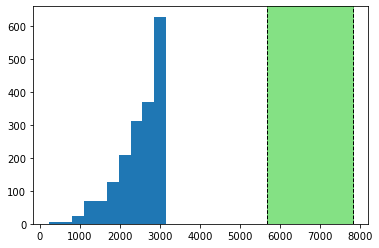